<a href="https://colab.research.google.com/github/Zuckmo/Capstone-Project---Waste-Classification/blob/main/YOLOv8_Plastik_Waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [3]:
# Install ultralytics (YOLOv5/YOLOv8)
!pip install ultralytics

In [6]:
import os
import numpy as np
import random
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
from ultralytics import YOLO

## **Data Loading**

In [ ]:
# Install kaggle dan kagglehub jika belum
!pip install -q kagglehub

import kagglehub

# Download dataset dari Kaggle (otomatis simpan ke cache)
path = kagglehub.dataset_download("aliefrahmanhakim/type-of-plastic-waste-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/type-of-plastic-waste-dataset


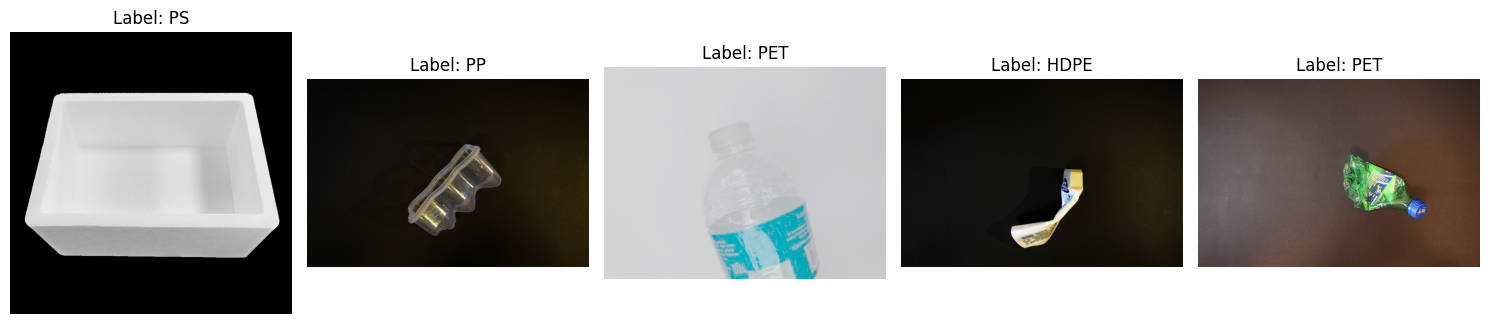

In [ ]:
# Path utama dataset
df = "/root/.cache/kagglehub/datasets/aliefrahmanhakim/type-of-plastic-waste-dataset/versions/2"

# Cari semua file gambar (dengan path lengkap)
image_paths = []
for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Tentukan jumlah gambar yang ingin ditampilkan
num_images_to_display = 5
selected_images = random.sample(image_paths, min(num_images_to_display, len(image_paths)))

# Tampilkan gambar-gambar secara horizontal
plt.figure(figsize=(15, 5))

for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    label = os.path.basename(os.path.dirname(image_path))

    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Total gambar dalam dataset: 14064


<ipython-input-19-3343796453>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x="Label", y="Jumlah Gambar", palette="Set2")


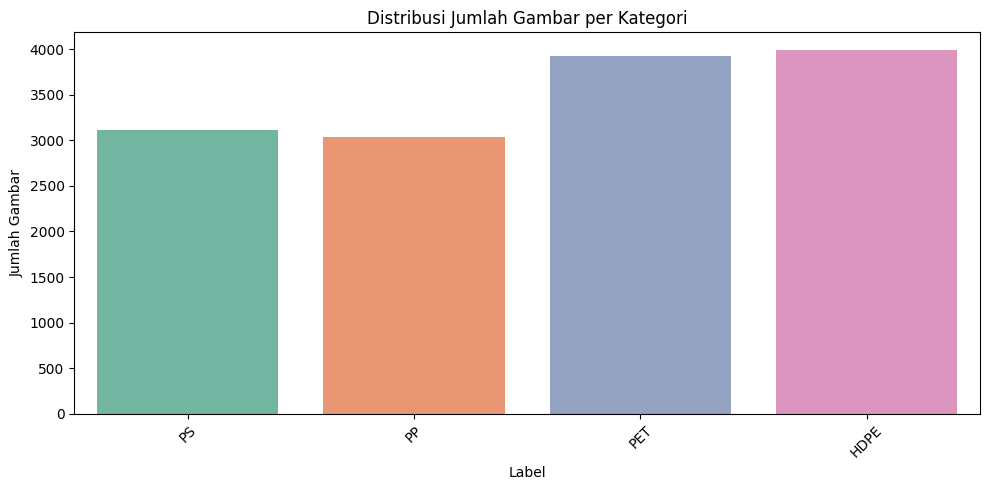

In [ ]:
# Hitung jumlah gambar per kategori
category_counts = {}
total_images = 0  # variabel untuk menghitung total semua gambar

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            label = os.path.basename(root)  # ambil nama folder langsung berisi gambar
            category_counts[label] = category_counts.get(label, 0) + 1
            total_images += 1

# Konversi ke DataFrame
df_counts = pd.DataFrame(list(category_counts.items()), columns=["Label", "Jumlah Gambar"])

# Print total gambar keseluruhan
print(f"Total gambar dalam dataset: {total_images}")

# Visualisasi bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=df_counts, x="Label", y="Jumlah Gambar", palette="Set2")
plt.title("Distribusi Jumlah Gambar per Kategori")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


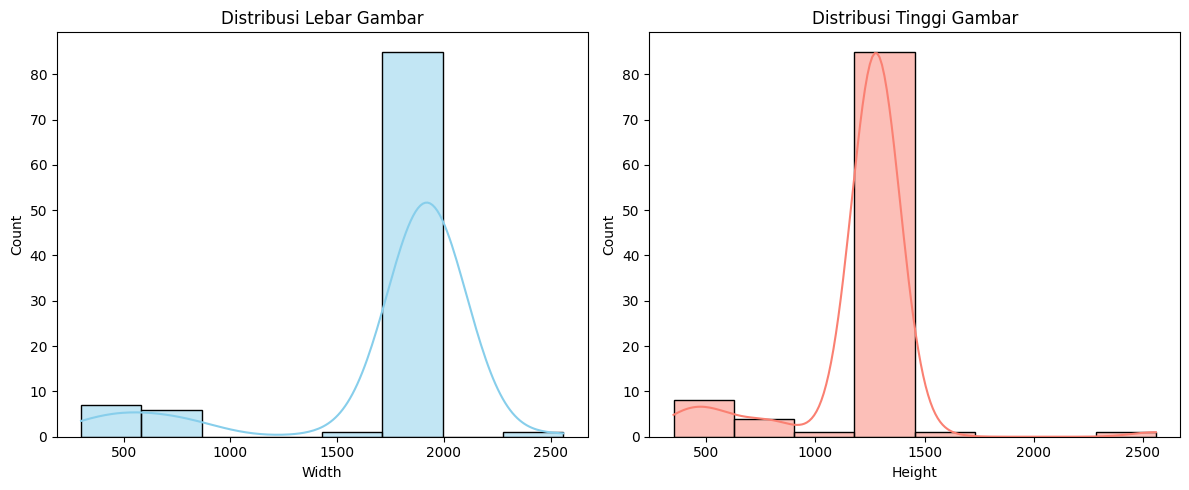

In [ ]:
# Ambil beberapa ukuran gambar secara acak
image_sizes = []
sample_images = random.sample(image_paths, min(100, len(image_paths)))  # contoh 100 gambar

for img_path in sample_images:
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)
    except:
        continue

# Konversi ke DataFrame
df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Visualisasi distribusi ukuran
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_sizes['Width'], kde=True, color='skyblue')
plt.title("Distribusi Lebar Gambar")

plt.subplot(1, 2, 2)
sns.histplot(df_sizes['Height'], kde=True, color='salmon')
plt.title("Distribusi Tinggi Gambar")

plt.tight_layout()
plt.show()

## **Data Preparation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (128, 128)
batch_size = 32

train_dir = os.path.join(df, "train")
val_dir = os.path.join(df, "val")

# Generator untuk train dan val
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 11252 images belonging to 4 classes.
Found 2812 images belonging to 4 classes.


In [ ]:
# Path asal dataset
source_base = '/kaggle/input/type-of-plastic-waste-dataset'
target_base = '/kaggle/working/plastic_yolo'

# Daftar class dari folder
classes = sorted(os.listdir(os.path.join(source_base, 'train')))
class_map = {cls: i for i, cls in enumerate(classes)}

# Fungsi untuk konversi
def convert_split(split):
    for cls in classes:
        image_dir = os.path.join(source_base, split, cls)
        label_dir = os.path.join(target_base, 'labels', split)
        output_img_dir = os.path.join(target_base, 'images', split)

        os.makedirs(label_dir, exist_ok=True)
        os.makedirs(output_img_dir, exist_ok=True)

        for img_file in os.listdir(image_dir):
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            img_path = os.path.join(image_dir, img_file)
            output_img_path = os.path.join(output_img_dir, f"{cls}_{img_file}")
            output_label_path = os.path.join(label_dir, f"{cls}_{os.path.splitext(img_file)[0]}.txt")

            # Copy image
            shutil.copy(img_path, output_img_path)

            # Simulasi bounding box: seluruh gambar
            with Image.open(img_path) as img:
                w, h = img.size
            x_center, y_center = 0.5, 0.5
            width, height = 1.0, 1.0
            class_id = class_map[cls]

            with open(output_label_path, 'w') as f:
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Jalankan konversi untuk train dan val
convert_split('train')
convert_split('val')

# Simpan config.yaml untuk YOLO
data_yaml = f"""
path: {target_base}
train: images/train
val: images/val
nc: {len(classes)}
names: {classes}
"""
with open('/kaggle/working/plastic_yolo.yaml', 'w') as f:
    f.write(data_yaml)

print("Dataset berhasil dikonversi ke format YOLO.")

Dataset berhasil dikonversi ke format YOLO.


## **Modelling**

In [31]:
model = YOLO('yolov8n.pt')

model.train(
    data='/kaggle/working/plastic_yolo.yaml',
    epochs=10,
    imgsz=128,
    batch=8
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 72.1MB/s]


Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/plastic_yolo.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=128, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

100%|██████████| 755k/755k [00:00<00:00, 14.3MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    752092  ultralytics.nn.modules.head.Detect           [4, [64, 128, 256]]           
Model summary: 129 layers, 3,011,628 parameters, 3,011,612 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 32.4±25.9 MB/s, size: 270.9 KB)


train: Scanning /kaggle/working/plastic_yolo/labels/train... 11252 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11252/11252 [00:41<00:00, 272.26it/s]


train: New cache created: /kaggle/working/plastic_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 2323.2±454.4 MB/s, size: 777.7 KB)


val: Scanning /kaggle/working/plastic_yolo/labels/val... 2812 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2812/2812 [00:02<00:00, 985.65it/s] 


val: New cache created: /kaggle/working/plastic_yolo/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G     0.2381      1.324     0.8878          4        128: 100%|██████████| 1407/1407 [12:31<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:48<00:00,  1.62it/s]

                   all       2812       2812      0.791      0.807      0.852      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.1658      0.749     0.8569          4        128: 100%|██████████| 1407/1407 [11:51<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:44<00:00,  1.69it/s]

                   all       2812       2812      0.832      0.835      0.917      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G     0.1478     0.6054     0.8545          4        128: 100%|██████████| 1407/1407 [11:47<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:47<00:00,  1.64it/s]

                   all       2812       2812       0.82      0.858      0.931      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.1237     0.4945     0.8524          4        128: 100%|██████████| 1407/1407 [11:56<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:36<00:00,  1.82it/s]

                   all       2812       2812      0.898      0.896      0.963      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.1054     0.4126     0.8484          4        128: 100%|██████████| 1407/1407 [11:39<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:40<00:00,  1.75it/s]

                   all       2812       2812      0.942      0.932      0.978      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G    0.09709      0.359     0.8497          4        128: 100%|██████████| 1407/1407 [11:37<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:36<00:00,  1.83it/s]

                   all       2812       2812      0.913       0.91      0.966      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G    0.08598     0.3177     0.8458          4        128: 100%|██████████| 1407/1407 [11:46<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:41<00:00,  1.74it/s]

                   all       2812       2812       0.94      0.942      0.982      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G    0.07492     0.2668     0.8477          4        128: 100%|██████████| 1407/1407 [11:23<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]

                   all       2812       2812      0.962      0.953      0.988      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G    0.06715     0.2202     0.8472          4        128: 100%|██████████| 1407/1407 [11:27<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:36<00:00,  1.82it/s]

                   all       2812       2812      0.954      0.954      0.988      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G    0.05795     0.1807     0.8453          4        128: 100%|██████████| 1407/1407 [11:16<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:39<00:00,  1.77it/s]

                   all       2812       2812      0.969      0.958       0.99      0.984



10 epochs completed in 2.237 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:33<00:00,  1.88it/s]


                   all       2812       2812      0.969      0.958       0.99      0.984
                  HDPE        797        797      0.981      0.974      0.993      0.993
                   PET        785        785      0.987      0.979      0.994      0.989
                    PP        607        607      0.942      0.965      0.986       0.98
                    PS        623        623      0.965      0.915      0.986      0.974
Speed: 0.1ms preprocess, 12.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78964cc95d90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [7]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

## **Evaluation**

In [33]:
metrics = model.val()  # Evaluasi ulang data val
print(metrics)

Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 586.6±386.6 MB/s, size: 436.4 KB)


val: Scanning /kaggle/working/plastic_yolo/labels/val.cache... 2812 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2812/2812 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 176/176 [01:27<00:00,  2.00it/s]


                   all       2812       2812      0.969      0.958       0.99      0.984
                  HDPE        797        797      0.981      0.974      0.993      0.993
                   PET        785        785      0.987      0.979      0.994      0.989
                    PP        607        607      0.942      0.965      0.986       0.98
                    PS        623        623      0.965      0.915      0.986      0.974
Speed: 0.1ms preprocess, 12.6ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x789647106410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    

In [34]:
from google.colab import files
uploaded = files.upload()

Saving kresek.jpg to kresek.jpg



image 1/1 /root/.cache/kagglehub/datasets/aliefrahmanhakim/type-of-plastic-waste-dataset/versions/2/train/PET/0006_a01b03c1d3e0f1g1h0_sharpen.jpg: 96x128 1 PET, 53.7ms
Speed: 4.4ms preprocess, 53.7ms inference, 20.1ms postprocess per image at shape (1, 3, 96, 128)


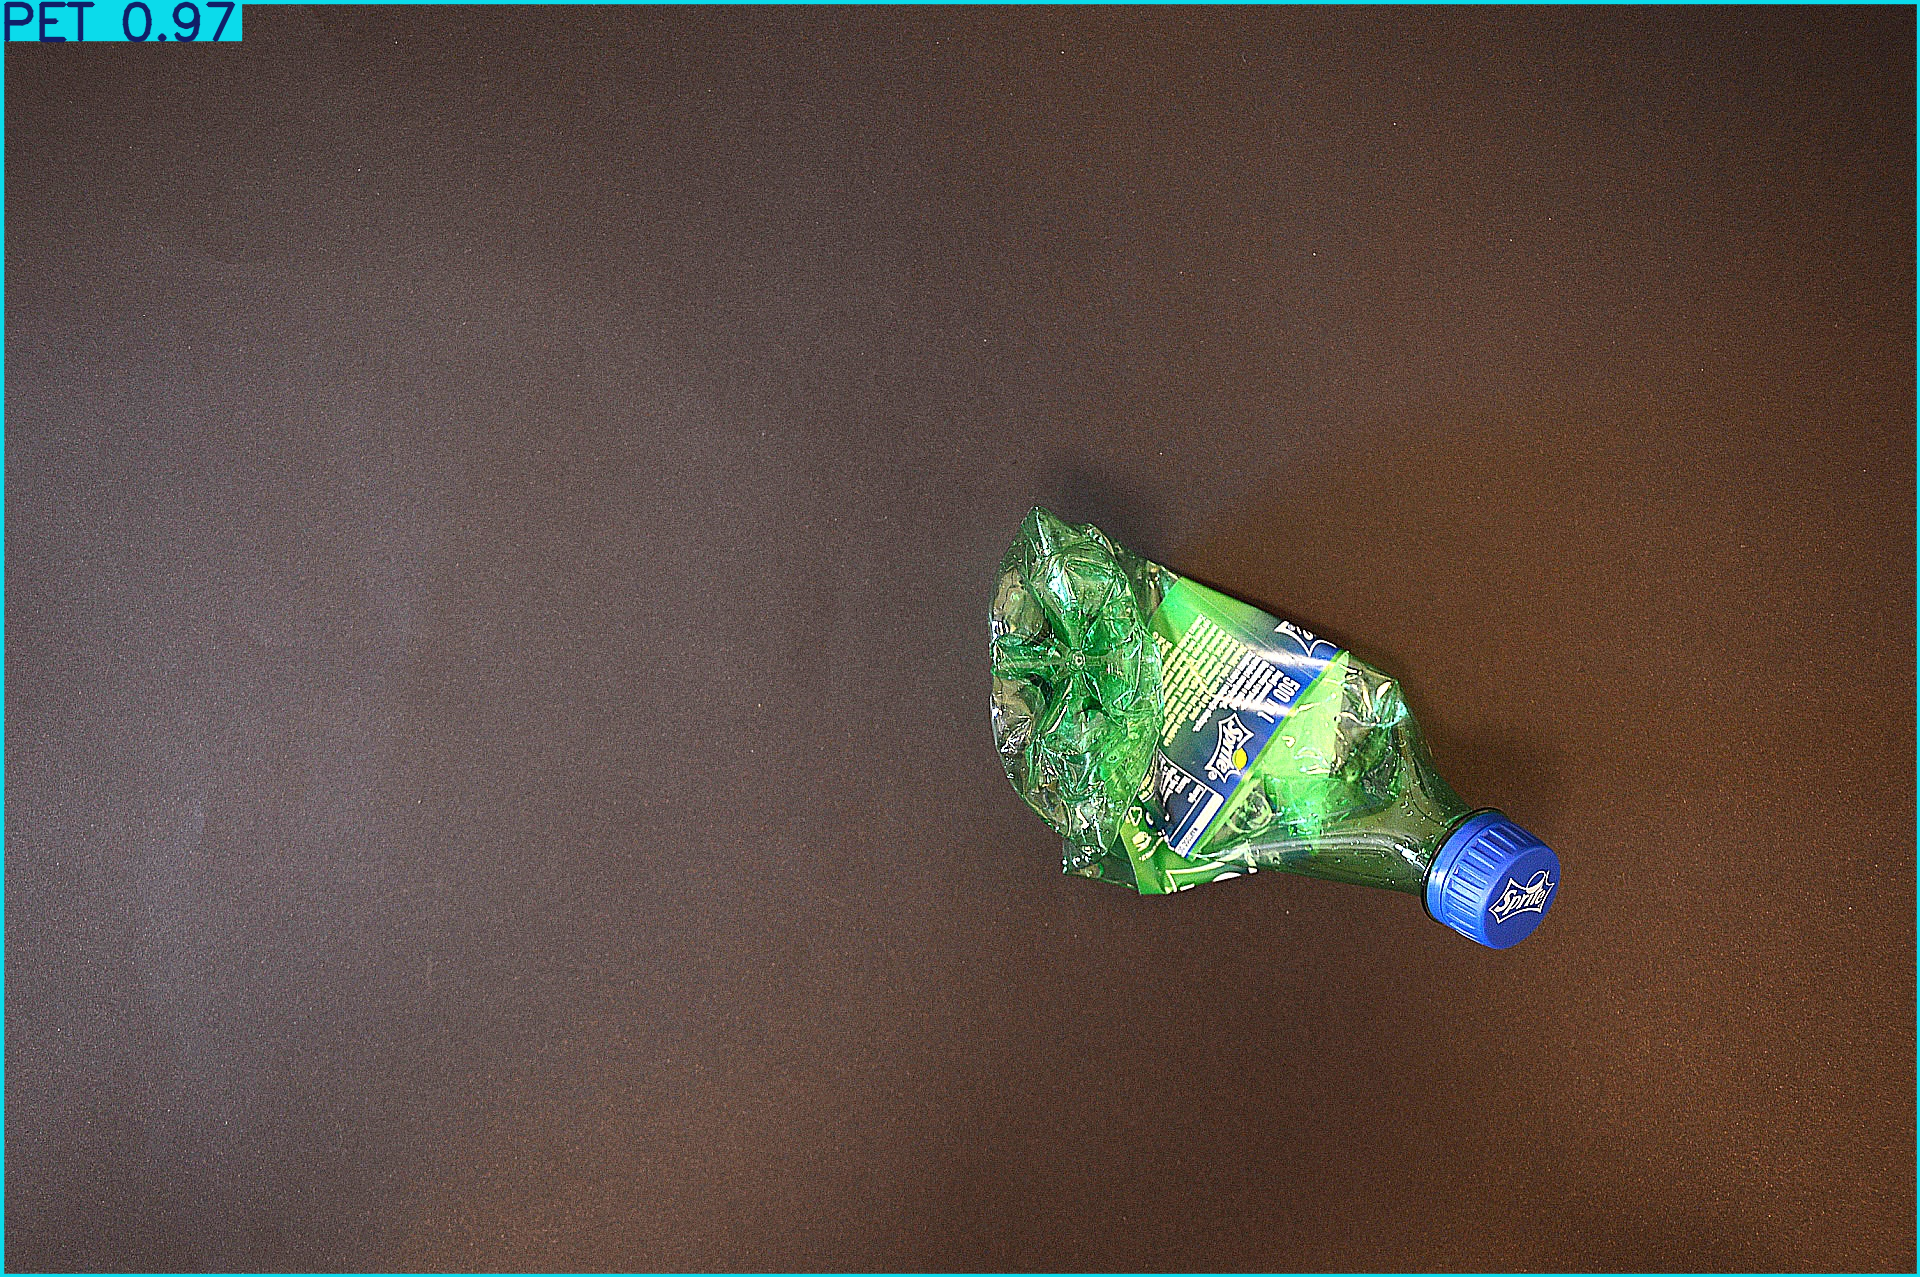

array([[[235, 219,  11],
        [235, 219,  11],
        [235, 219,  11],
        ...,
        [235, 219,  11],
        [235, 219,  11],
        [235, 219,  11]],

       [[235, 219,  11],
        [235, 219,  11],
        [235, 219,  11],
        ...,
        [235, 219,  11],
        [235, 219,  11],
        [235, 219,  11]],

       [[235, 219,  11],
        [235, 219,  11],
        [235, 219,  11],
        ...,
        [235, 219,  11],
        [235, 219,  11],
        [235, 219,  11]],

       ...,

       [[235, 219,  11],
        [235, 219,  11],
        [235, 219,  11],
        ...,
        [235, 219,  11],
        [235, 219,  11],
        [235, 219,  11]],

       [[235, 219,  11],
        [235, 219,  11],
        [235, 219,  11],
        ...,
        [235, 219,  11],
        [235, 219,  11],
        [235, 219,  11]],

       [[235, 219,  11],
        [235, 219,  11],
        [235, 219,  11],
        ...,
        [235, 219,  11],
        [235, 219,  11],
        [235, 219,  11]]

In [35]:
import matplotlib.pyplot as plt

# Deteksi
results = model(image_path)

# Plot langsung
results[0].plot(show=True)



image 1/1 /kaggle/working/plastic_yolo/images/val/HDPE_0010_a02b01c2d0e0f1g0h1_change_contrast.jpg: 96x128 1 HDPE, 16.1ms
Speed: 0.6ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 128)
Results saved to runs/detect/predict
Path hasil deteksi: runs/detect/predict/HDPE_0010_a02b01c2d0e0f1g0h1_change_contrast.jpg
Apakah file ada? True


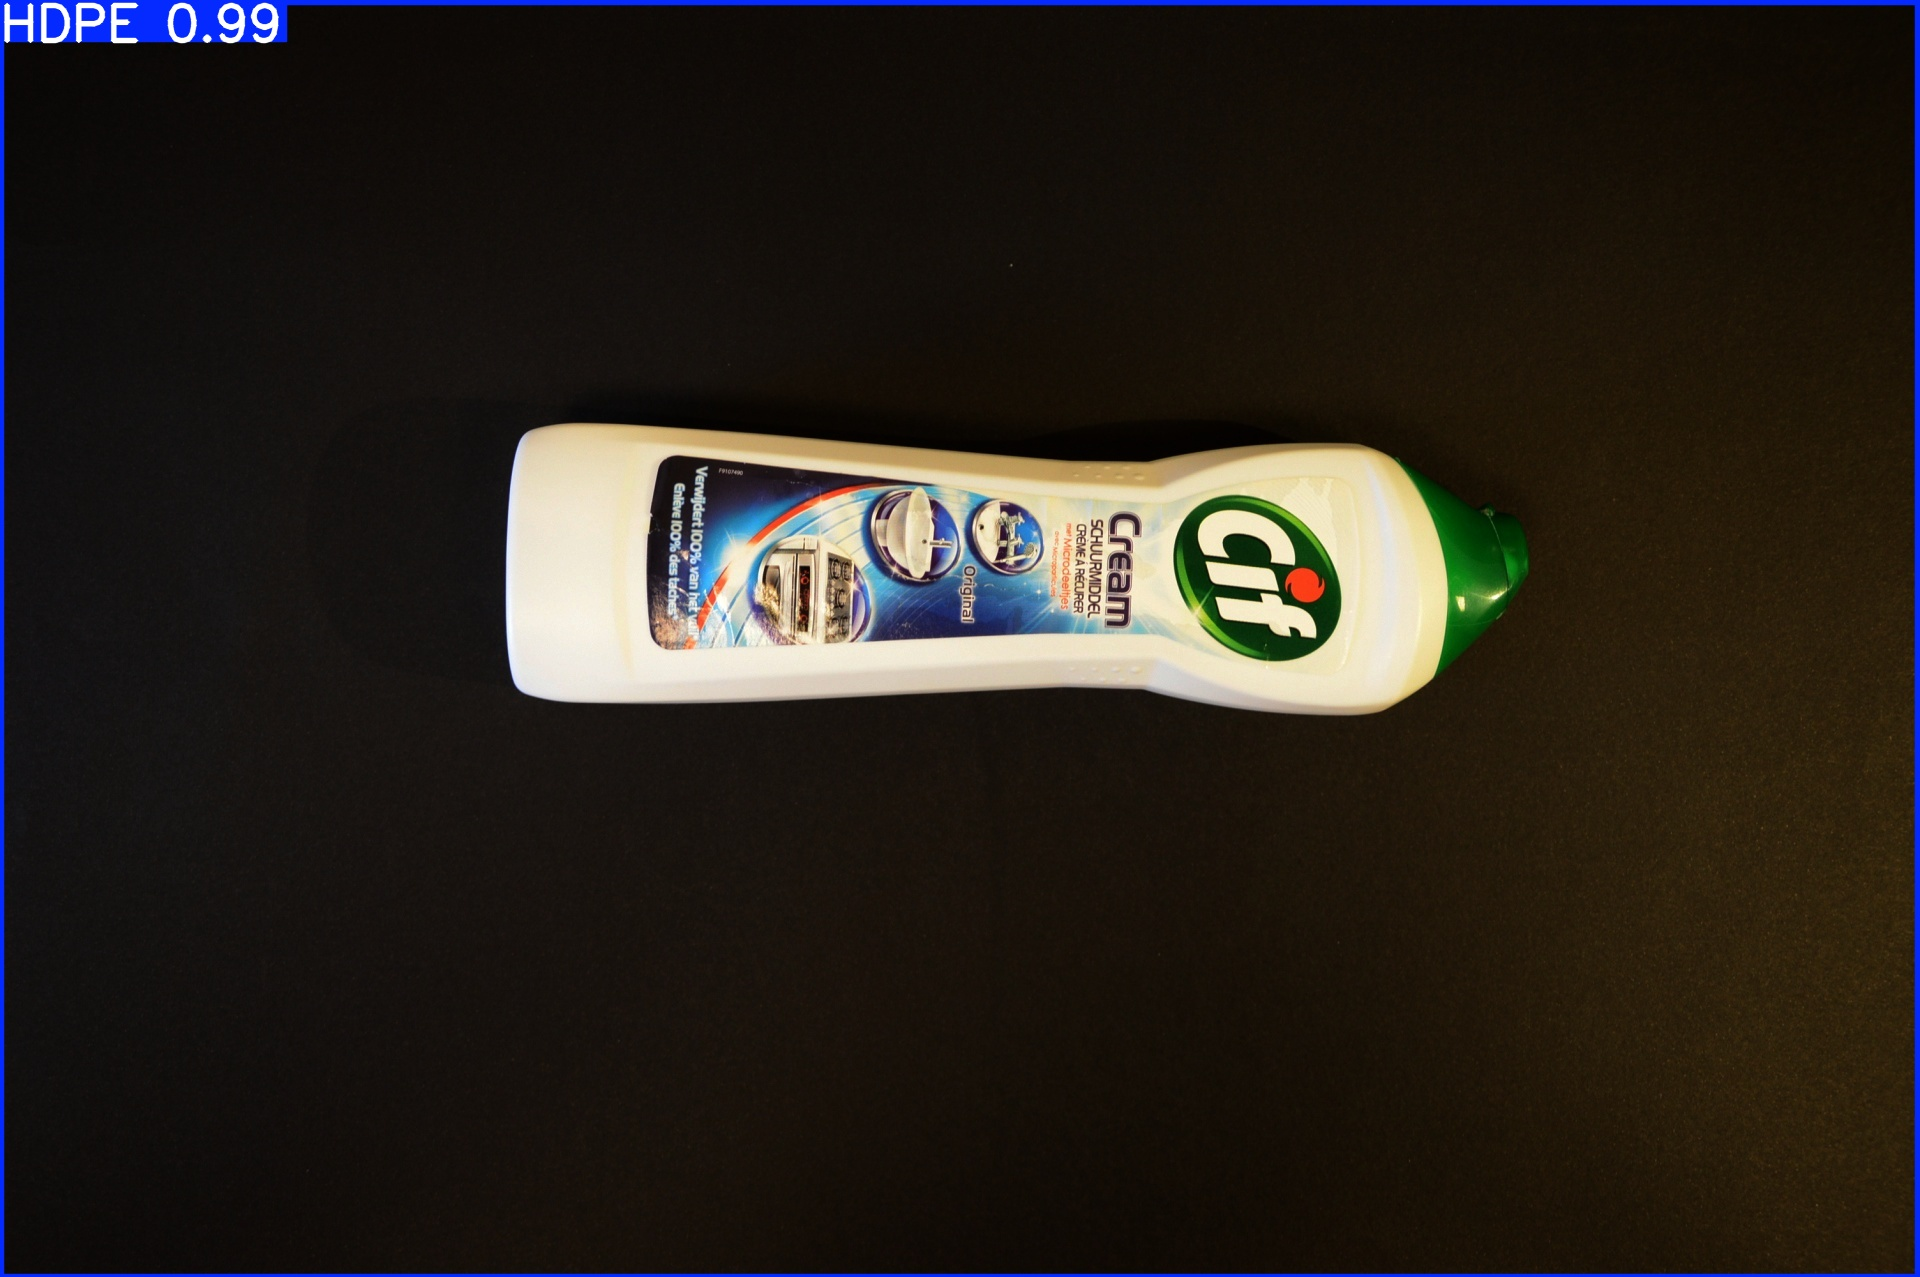

In [36]:
from IPython.display import Image as IPImage, display
import os

# Path gambar uji coba
test_image_path = '/kaggle/working/plastic_yolo/images/val/HDPE_0010_a02b01c2d0e0f1g0h1_change_contrast.jpg'

# Prediksi dan simpan hasil (gambar & bounding box)
results = model(test_image_path, save=True)

# Ambil direktori hasil simpan otomatis dari YOLO
output_dir = results[0].save_dir  # biasanya 'runs/detect/predict'
saved_image_path = os.path.join(output_dir, os.path.basename(test_image_path))

# Debug
print(f"Path hasil deteksi: {saved_image_path}")
print(f"Apakah file ada? {os.path.exists(saved_image_path)}")

# Tampilkan hasilnya
if os.path.exists(saved_image_path):
    display(IPImage(filename=saved_image_path))
else:
    print("Gambar hasil tidak ditemukan. Cek kembali nama file.")